# DATA PREPROCESSING

In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

Read cleaned data set

In [8]:
df = pd.read_csv('../data/train_cleaned.csv')
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,8.674026,0.0,4.852030,5.886104,Yes,Urban,1
1,Male,Yes,1,Graduate,No,8.430109,1508.0,4.852030,5.886104,Yes,Rural,0
2,Male,Yes,0,Graduate,Yes,8.006368,0.0,4.189655,5.886104,Yes,Urban,1
3,Male,Yes,0,Not Graduate,No,7.856707,2358.0,4.787492,5.886104,Yes,Urban,1
4,Male,No,0,Graduate,No,8.699515,0.0,4.948760,5.886104,Yes,Urban,1


We will look at the correlation of numerical features and target feature

<Axes: >

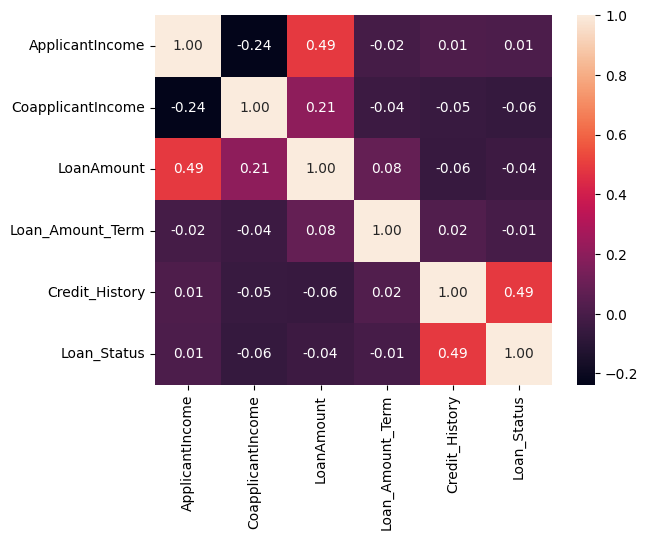

In [4]:
cor = df.corr(numeric_only=True, )
sns.heatmap(cor,annot=True,fmt='.2f')

Compute mutual score information between categorical feature and target feature

In [5]:
from sklearn.metrics import mutual_info_score

cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area']

def compute_mi_score(feature):
    return round(mutual_info_score(feature, df.Loan_Status), 4)

df[cat_features].apply(compute_mi_score).sort_values(ascending=False)

Credit_History    0.1139
Property_Area     0.0102
Married           0.0041
Education         0.0036
Dependents        0.0026
Gender            0.0002
Self_Employed     0.0000
dtype: float64

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Loan_Status', axis=1), df.Loan_Status,
                                                    stratify=df.Loan_Status,test_size=0.2, random_state=29)

In [19]:
def data_transformer():
    num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term']
    cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area']
    
    # num_features = ['ApplicantIncome', 'CoapplicantIncome',  'LoanAmount']
    # cat_features = ['Credit_History']
    
    num_pipe = Pipeline([
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('ohe', OneHotEncoder(sparse_output=False)),
        ('scaler', StandardScaler())
    ])
    
    pipe = ColumnTransformer([
        ('num_pipe', num_pipe, num_features),
        ('cat_pipe', cat_pipe, cat_features)
    ])
    
    return pipe    

In [20]:
transformer = data_transformer()
X_train = transformer.fit_transform(x_train)
X_test = transformer.transform(x_test)

We will apply RFE method to select important features for training models

In [17]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier()            # Instantiate a random forest classifier (or any other model)
# rfe = RFE(model, n_features_to_select=10)    # Select top 5 features
# rfe.fit(X_train, y_train)
# features_names = transformer.get_feature_names_out()
# features_names[rfe.support_]

# TRAIN MODEL

In [64]:
# from imblearn.pipeline import Pipeline as imbpipeline
# from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

Our target feature is quite imbalance, so we will use f1_weighted to evaluate performance of models

In [65]:
# Pipeline
pipe_base = Pipeline(steps=[
    ['classifier', LogisticRegression()]
], memory="cache_folder")

# Grid of all base models
param_base = [
    {'classifier': [LogisticRegression(random_state=29)]}, {'classifier': [SVC(random_state=29)]},
    {'classifier': [DecisionTreeClassifier(random_state=29)]}, {'classifier': [RandomForestClassifier(random_state=29)]},
    {'classifier': [AdaBoostClassifier(random_state=29)]}, {'classifier': [KNeighborsClassifier()]},
    {'classifier': [GradientBoostingClassifier(random_state=29)]}
]

# Scoring metrics
scoring = {
    'auc': 'roc_auc',
    'f1_weighted': 'f1_weighted',
}

# KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)

In [66]:
base_grid = GridSearchCV(estimator = pipe_base, param_grid = param_base, cv = cv, scoring=scoring, refit='f1_weighted', return_train_score=True)

In [67]:
%time print(base_grid.fit(X_train, y_train))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(memory='cache_folder',
                                steps=[['classifier', LogisticRegression()]]),
             param_grid=[{'classifier': [LogisticRegression(random_state=29)]},
                         {'classifier': [SVC(random_state=29)]},
                         {'classifier': [DecisionTreeClassifier(random_state=29)]},
                         {'classifier': [RandomForestClassifier(random_state=29)]},
                         {'classifier': [AdaBoostClassifier(random_state=29)]},
                         {'classifier': [KNeighborsClassifier()]},
                         {'classifier': [GradientBoostingClassifier(random_state=29)]}],
             refit='f1_weighted', return_train_score=True,
             scoring={'auc': 'roc_auc', 'f1_weighted': 'f1_weighted'})
CPU times: user 4 s, sys: 81.7 ms, total: 4.08 s
Wall time: 4.28 s


In [68]:
base_grid_best_estimator = base_grid.best_estimator_['classifier']
print('Best estimator: %s' % base_grid_best_estimator)
print('Best score: %.10f' % base_grid.best_score_)

Best estimator: LogisticRegression(random_state=29)
Best score: 0.7808096881


Let's plot the learning curve

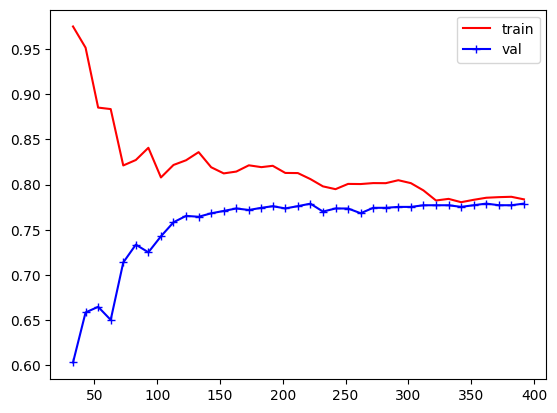

In [26]:
train_size, train_score, val_score = learning_curve(base_grid_best_estimator, X_train, y_train, 
                        train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring='f1_weighted')

train_score = np.mean(train_score, axis=1)
val_score = np.mean(val_score, axis=1)

plt.plot(train_size, train_score, 'r-', label='train')
plt.plot(train_size, val_score, 'b-+', label='val')
plt.legend()

plt.show()

From the plot, we can supppose that our base model is quite simple thus underfit the data. Let's look at the ROC curve

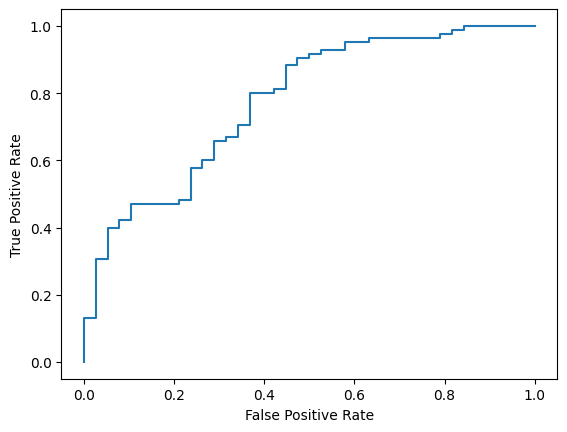

In [27]:
y_pred = base_grid_best_estimator.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

The ROC curve showed that there are more rooms for improvement. Let look at the performance of our base models.

In [28]:
base_grid_result = pd.DataFrame(base_grid.cv_results_).drop(columns=['params'])
base_grid_result['classifier_name'] = base_grid_result['param_classifier'].astype(str).str.replace(r"\(.*\)","")
base_grid_result[['rank_test_f1_weighted', 'classifier_name', 'mean_test_auc', 'std_test_auc', 'mean_train_auc', 'std_train_auc', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'mean_train_f1_weighted', 'std_train_f1_weighted']].sort_values('rank_test_f1_weighted')

,rank_test_f1_weighted,classifier_name,mean_test_auc,std_test_auc,mean_train_auc,std_train_auc,mean_test_f1_weighted,std_test_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted
0,1,LogisticRegression(random_state=29),0.725268,0.053659,0.781565,0.012974,0.780810,0.028163,0.781593,0.008841
1,1,LinearSVC(random_state=29),0.725184,0.055298,0.781420,0.013082,0.780810,0.028163,0.781137,0.008767
4,3,AdaBoostClassifier(random_state=29),0.736839,0.042007,0.907624,0.007029,0.770503,0.022608,0.840005,0.009100
6,4,GradientBoostingClassifier(random_state=29),0.729641,0.012633,0.981375,0.004445,0.765214,0.023615,0.898189,0.007850
3,5,RandomForestClassifier(random_state=29),0.760811,0.044793,1.000000,0.000000,0.756852,0.027676,1.000000,0.000000
5,6,KNeighborsClassifier(),0.719529,0.031917,0.885882,0.008133,0.732702,0.019445,0.812357,0.011190
2,7,DecisionTreeClassifier(random_state=29),0.673966,0.046814,1.000000,0.000000,0.725707,0.043018,1.000000,0.000000


# TUNING HYPEPARAMETERS

Because our data is quite small, we will carefully choose the hyperparameters for our models to avoid overfitting, especially the tree-based models.

In [82]:
params_best = [
    {'classifier': [LogisticRegression(random_state=29)], 'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.1, 0.5, 1, 5]},
    {'classifier': [SGDClassifier(random_state=29)], 'classifier__penalty': ['l1', 'l2'], 'classifier__alpha': [0.1, 0.5, 1, 5], 'classifier__learning_rate': ['constant', 'adaptive'], 'classifier__eta0': [0.01, 0.1, 0.5]},
    {'classifier': [SVC(random_state=29)], 'classifier__kernel': ['rbf', 'poly'], 'classifier__degree': [2, 3, 4], 'classifier__C': [0.1, 0.5, 1, 5]},
    {'classifier': [KNeighborsClassifier()], 'classifier__n_neighbors': [2, 5, 10, 15], 'classifier__p': [1, 2]},
    {'classifier': [DecisionTreeClassifier(random_state=29)], 'classifier__max_depth': [2, 10, 50, 100], 'classifier__min_samples_split': [5, 10, 20], 'classifier__min_samples_leaf' : [5, 10, 20]},
    {'classifier': [RandomForestClassifier(random_state=29)], 'classifier__max_depth': [2, 5, 10], 'classifier__min_samples_split': [5, 10, 20], 'classifier__min_samples_leaf' : [5, 10, 20], 'classifier__n_estimators': [2, 5, 10]},
    {'classifier': [AdaBoostClassifier(random_state=29)], 'classifier__learning_rate': [0.1, 1], 'classifier__n_estimators': [5, 10, 20, 50]},
    {'classifier': [GradientBoostingClassifier(random_state=29)], 'classifier__learning_rate': [0.1, 1], 'classifier__min_samples_split': [5, 10, 20], 'classifier__min_samples_leaf' : [5, 10, 20], 'classifier__max_features' : ['auto', 'sqrt'], 'classifier__n_estimators': [2, 5, 10]}
]

In [83]:
best_grid_results.sort_values('rank_test_f1_weighted')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__alpha,param_classifier__eta0,param_classifier__learning_rate,param_classifier__n_neighbors,param_classifier__p,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__max_features,split0_test_auc,split1_test_auc,split2_test_auc,split3_test_auc,split4_test_auc,mean_test_auc,std_test_auc,rank_test_auc,split0_train_auc,split1_train_auc,split2_train_auc,split3_train_auc,split4_train_auc,mean_train_auc,std_train_auc,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,split3_train_f1_weighted,split4_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,classifier_name
61,0.035881,0.000931,0.004025,0.000173,LinearSVC(random_state=29),1,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777514,0.709677,0.639384,0.792971,0.706373,0.725184,0.055298,179,0.764590,0.789371,0.796658,0.766908,0.789573,0.781420,0.013082,0.794564,0.75339,0.757301,0.82924,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.781665,0.781137,0.008767,LinearSVC(random_state=29)
1,0.007012,0.001574,0.008570,0.002377,LogisticRegression(random_state=29),0.1,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.781309,0.712085,0.649494,0.795378,0.701471,0.727947,0.053855,139,0.765467,0.790123,0.798073,0.767299,0.789243,0.782041,0.013162,0.794564,0.75339,0.757301,0.82924,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
57,0.008943,0.001089,0.004367,0.000858,LinearSVC(random_state=29),0.1,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779886,0.710159,0.640828,0.792008,0.707353,0.726047,0.054979,175,0.764923,0.789160,0.796688,0.766667,0.789423,0.781372,0.013014,0.794564,0.75339,0.757301,0.82924,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.781665,0.781137,0.008767,LinearSVC(random_state=29)
3,0.006829,0.001377,0.006302,0.001966,LogisticRegression(random_state=29),0.5,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779412,0.708233,0.646606,0.791045,0.702941,0.725647,0.053355,176,0.765285,0.789551,0.797170,0.767148,0.789483,0.781728,0.012982,0.794564,0.75339,0.757301,0.82924,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
5,0.004485,0.000714,0.011372,0.004304,LogisticRegression(random_state=29),1,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.778463,0.708233,0.644680,0.791045,0.703922,0.725268,0.053659,178,0.765165,0.789341,0.796929,0.766938,0.789453,0.781565,0.012974,0.794564,0.75339,0.757301,0.82924,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
7,0.004290,0.000473,0.007388,0.000777,LogisticRegression(random_state=29),5,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777514,0.707752,0.644198,0.790563,0.702941,0.724594,0.053607,181,0.765104,0.789431,0.796718,0.767148,0.789573,0.781595,0.012918,0.794564,0.75339,0.757301,0.82924,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
59,0.033029,0.003651,0.004509,0.000841,LinearSVC(random_state=29),0.5,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777989,0.709677,0.638421,0.792971,0.706373,0.725086,0.055687,180,0.764621,0.788919,0.796778,0.766877,0.789633,0.781366,0.013063,0.794564,0.75339,0.757301,0.82924,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.781665,0.781137,0.008767,LinearSVC(random_state=29)
9,0.002672,0.000405,0.004821,0.000751,SGDClassifier(random_state=29),NaN,l2,0.1,0.01,constant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762808,0.649494,0.606644

In [84]:
best_grid = GridSearchCV(estimator=pipe_base, param_grid=params_best, cv=cv, scoring=scoring, refit='f1_weighted', return_train_score=True)

In [85]:
%time print(best_grid.fit(X_train, y_train))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(memory='cache_folder',
                                steps=[['classifier', LogisticRegression()]]),
             param_grid=[{'classifier': [LogisticRegression(random_state=29)],
                          'classifier__C': [0.1, 0.5, 1, 5],
                          'classifier__penalty': ['l1', 'l2']},
                         {'classifier': [SGDClassifier(random_state=29)],
                          'classifier__al...
                         {'classifier': [GradientBoostingClassifier(random_state=29)],
                          'classifier__learning_rate': [0.1, 1],
                          'classifier__max_features': ['auto', 'sqrt'],
                          'classifier__min_samples_leaf': [5, 10, 20],
                          'classifier__min_samples_split': [5, 10, 20],
                          'classifier__n_estimators': [2, 5, 10]}],
             refit='f1_weighted'

In [97]:
best_grid_best_estimator = best_grid.best_estimator_['classifier']
print('Best estimator: %s' % best_grid_best_estimator)
print('Best score: %.10f' % best_grid.best_score_)

Best estimator: LogisticRegression(C=0.1, random_state=29)
Best score: 0.7808096881


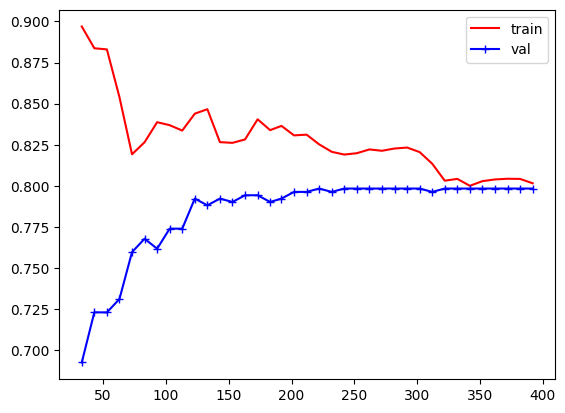

In [98]:
train_size, train_score, val_score = learning_curve(best_grid_best_estimator, X_train, y_train, 
                        train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring='accuracy')

train_score = np.mean(train_score, axis=1)
val_score = np.mean(val_score, axis=1)

plt.plot(train_size, train_score, 'r-', label='train')
plt.plot(train_size, val_score, 'b-+', label='val')
plt.legend()

plt.show()

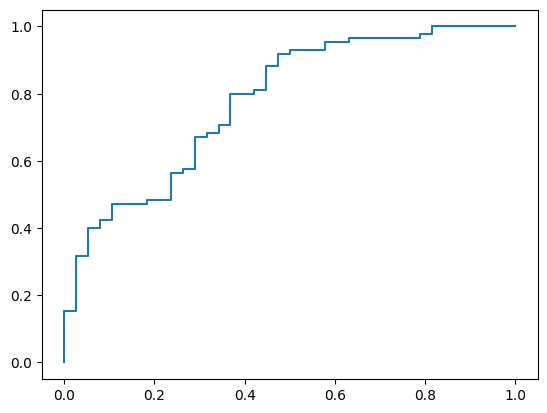

In [99]:
y_pred = best_grid_best_estimator.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

This model still needed improvement

In [112]:
best_grid_results = pd.DataFrame(best_grid.cv_results_).drop('params', axis=1)
best_grid_results['classifier_name'] = best_grid_results['param_classifier'].astype(str).str.replace(r"\(.*\)", "")
best_grid_results.sort_values('rank_test_f1_weighted')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__alpha,param_classifier__eta0,param_classifier__learning_rate,param_classifier__degree,param_classifier__kernel,param_classifier__n_neighbors,param_classifier__p,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__max_features,split0_test_auc,split1_test_auc,split2_test_auc,split3_test_auc,split4_test_auc,mean_test_auc,std_test_auc,rank_test_auc,split0_train_auc,split1_train_auc,split2_train_auc,split3_train_auc,split4_train_auc,mean_train_auc,std_train_auc,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,split3_train_f1_weighted,split4_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,classifier_name
1,0.015854,0.012607,0.008372,0.001172,LogisticRegression(random_state=29),0.1,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.781309,0.712085,0.649494,0.795378,0.701471,0.727947,0.053855,104,0.765467,0.790123,0.798073,0.767299,0.789243,0.782041,0.013162,0.794564,0.75339,0.757301,0.829240,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
3,0.004632,0.001010,0.004448,0.000434,LogisticRegression(random_state=29),0.5,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779412,0.708233,0.646606,0.791045,0.702941,0.725647,0.053355,132,0.765285,0.789551,0.797170,0.767148,0.789483,0.781728,0.012982,0.794564,0.75339,0.757301,0.829240,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
5,0.003821,0.000323,0.004426,0.000716,LogisticRegression(random_state=29),1,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.778463,0.708233,0.644680,0.791045,0.703922,0.725268,0.053659,135,0.765165,0.789341,0.796929,0.766938,0.789453,0.781565,0.012974,0.794564,0.75339,0.757301,0.829240,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
7,0.003713,0.000583,0.004606,0.000699,LogisticRegression(random_state=29),5,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777514,0.707752,0.644198,0.790563,0.702941,0.724594,0.053607,136,0.765104,0.789431,0.796718,0.767148,0.789573,0.781595,0.012918,0.794564,0.75339,0.757301,0.829240,0.769554,0.780810,0.028163,1,0.778799,0.789192,0.790144,0.765888,0.783945,0.781593,0.008841,LogisticRegression(random_state=29)
9,0.002913,0.000688,0.006043,0.001590,SGDClassifier(random_state=29),NaN,l2,0.1,0.01,constant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762808,0.649494,0.606644,0.776119,0.738725,0.706758,0.066748,209,0.752289,0.705149,0.753177,0.654743,0.772245,0.727521,0.042589,0.794564,0.75339,0.757301,0.829240,0.769554,0.780810,0.028163,1,0.781077,0.789192,0.786904,0.765888,0.781665,0.780945,0.008133,SGDClassifier(random_state=29)
207,0.043679,0.001637,0.012652,0.000308,AdaBoostClassifier(random_state=29),NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,0.785816,0.677179,0.665142,0.827877,0.720833,0.735369,0.062661,70,0.788104,0.773050,0.780518,0.776152,0.796453,0.782855,0.008473,0.785473,0.75339,0.757301,0.829240,0.769554,0.778991,0.027502,6,0.785408,0.785925,0.784621,0.765888,0.781665,0.780701,0.007552,AdaBoostClassifier(random_state=29)
208,0.107004,0.002044,0.024100,0.001010,AdaBoostClassifier(random_state=29),NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,NaN,0.761148,0.705826,0.672123,0.792248,0.760784,0.738426,0.043294,58,0.833817,0.817148,0.836781,0.823683,0.836281,0.829542,0.007798,0.794564,0.75339,0.748441,0.817261,0.778569,0.778445,0.025669,7,0.787701,0.790504,0.789192,0.777171,0.783945,0.785702,0.004798,AdaBoostClassifier(r

Let's look at the performance of our best model

In [101]:
best_grid

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(memory='cache_folder',
                                steps=[['classifier', LogisticRegression()]]),
             param_grid=[{'classifier': [LogisticRegression(random_state=29)],
                          'classifier__C': [0.1, 0.5, 1, 5],
                          'classifier__penalty': ['l1', 'l2']},
                         {'classifier': [SGDClassifier(random_state=29)],
                          'classifier__al...
                         {'classifier': [GradientBoostingClassifier(random_state=29)],
                          'classifier__learning_rate': [0.1, 1],
                          'classifier__max_features': ['auto', 'sqrt'],
                          'classifier__min_samples_leaf': [5, 10, 20],
                          'classifier__min_samples_split': [5, 10, 20],
                          'classifier__n_estimators': [2, 5, 10]}],
             refit='f1_weighted', return_train_score=True,
             scoring={'auc': 'roc_auc', 'f1_weighted': 'f1_weighted'})

In [102]:
best_classifier = best_grid.best_estimator_['classifier']
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.39      0.53        38
           1       0.78      0.95      0.86        85

    accuracy                           0.78       123
   macro avg       0.78      0.67      0.69       123
weighted avg       0.78      0.78      0.75       123



The model 

# BAGGING METHOD

## Voting Classifier

In [103]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier

In [143]:
voting_clf = VotingClassifier([
    ('logis', best_grid_best_estimator),
    ('rf', RandomForestClassifier(max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10, random_state=29)),
    ('knn', KNeighborsClassifier(n_neighbors=10, p=2))
])
voting_clf.voting = 'soft'
voting_scores = cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring='f1_weighted')
print(np.mean(voting_scores))

0.7676371479905743


In [111]:
bagging_clf = BaggingClassifier(best_grid_best_estimator, 
                                n_estimators=5, max_samples=0.8, max_features=0.8, random_state=29)
bagging_scores = cross_val_score(bagging_clf, X_train, y_train, cv=cv, scoring='f1_weighted')
print(np.mean(bagging_scores))

0.7782823064438218


# SAVE BEST MODEL